In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# Load dataset
df = pd.read_csv(r"C:\Users\psant\OneDrive\Documents\Heart_Attack_Prediction\heart_attack_prediction_dataset.csv")

C:\Users\psant\AppData\Local\Temp\ipykernel_21540\2158946752.py:2: DtypeWarning: Columns (0,2,4,12,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\psant\OneDrive\Documents\Heart_Attack_Prediction\heart_attack_prediction_dataset.csv")


In [29]:
print(df.columns)


Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')


In [30]:
print(df.dtypes)


Patient ID                          object
Age                                float64
Sex                                 object
Cholesterol                        float64
Blood Pressure                      object
Heart Rate                         float64
Diabetes                           float64
Family History                     float64
Smoking                            float64
Obesity                            float64
Alcohol Consumption                float64
Exercise Hours Per Week            float64
Diet                                object
Previous Heart Problems            float64
Medication Use                     float64
Stress Level                       float64
Sedentary Hours Per Day            float64
Income                             float64
BMI                                float64
Triglycerides                      float64
Physical Activity Days Per Week    float64
Sleep Hours Per Day                float64
Country                             object
Continent  

In [31]:
# Drop irrelevant columns
df.drop(columns=['Patient ID'], inplace=True)

# Convert categorical columns to numeric using Label Encoding
categorical_cols = ['Sex', 'Diet', 'Country', 'Continent', 'Hemisphere']
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))

# Convert 'Blood Pressure' into two separate numeric columns (Systolic & Diastolic)
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)
df.drop(columns=['Blood Pressure'], inplace=True)

# Fill missing values
df.fillna(df.median(), inplace=True)

In [32]:
# Feature scaling
scaler = StandardScaler()
X = df.drop(columns=['Heart Attack Risk'])
y = df['Heart Attack Risk']
X_scaled = scaler.fit_transform(X)

In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Handle imbalance
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [35]:
models = {
    "XGBoost": XGBClassifier(tree_method='hist', device='cuda', n_jobs=-1),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(task_type='GPU', verbose=0),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=10, max_features='sqrt', 
                                            class_weight='balanced', warm_start=True, n_jobs=-1, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=5000, solver='lbfgs'),
    "KNN": KNeighborsClassifier(n_neighbors=7, algorithm='auto', weights='distance', n_jobs=-1)
}

In [37]:
param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}

random_search = RandomizedSearchCV(XGBClassifier(tree_method='hist', device='cuda', n_jobs=-1), 
                                   param_distributions=param_dist,
                                   n_iter=10, scoring='accuracy', cv=3, verbose=1)

random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [41]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    results[name] = {'Accuracy': acc, 'AUC-ROC': auc}
    
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

XGBoost Accuracy: 0.9962
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    209087
         1.0       0.36      0.36      0.36       628

    accuracy                           1.00    209715
   macro avg       0.68      0.68      0.68    209715
weighted avg       1.00      1.00      1.00    209715

Confusion Matrix:
[[208691    396]
 [   405    223]]
--------------------------------------------------
[LightGBM] [Info] Number of positive: 836349, number of negative: 836349
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5001
[LightGBM] [Info] Number of data points in the train set: 1672698, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\psant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\psant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9959
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    209087
         1.0       0.34      0.39      0.37       628

    accuracy                           1.00    209715
   macro avg       0.67      0.70      0.68    209715
weighted avg       1.00      1.00      1.00    209715

Confusion Matrix:
[[208611    476]
 [   380    248]]
--------------------------------------------------
CatBoost Accuracy: 0.9955
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    209087
         1.0       0.36      0.68      0.47       628

    accuracy                           1.00    209715
   macro avg       0.68      0.84      0.74    209715
weighted avg       1.00      1.00      1.00    209715

Confusion Matrix:
[[208345    742]
 [   203    425]]
--------------------------------------------------


c:\Users\psant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\psant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:466: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


RandomForest Accuracy: 0.9946
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    209087
         1.0       0.36      1.00      0.52       628

    accuracy                           0.99    209715
   macro avg       0.68      1.00      0.76    209715
weighted avg       1.00      0.99      1.00    209715

Confusion Matrix:
[[207949   1138]
 [     0    628]]
--------------------------------------------------
LogisticRegression Accuracy: 0.9945
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    209087
         1.0       0.35      1.00      0.52       628

    accuracy                           0.99    209715
   macro avg       0.68      1.00      0.76    209715
weighted avg       1.00      0.99      1.00    209715

Confusion Matrix:
[[207944   1143]
 [     0    628]]
--------------------------------------------------
KNN Accuracy: 0.9946
              precision    recall  f1-score   suppo

In [51]:
# Prediction & Risk Classification
# Predict probabilities using the trained model
y_prob = best_xgb.predict_proba(X_test)[:, 1]

# Define risk levels
risk_levels = np.where(y_prob < 0.33, "Low Risk", 
                       np.where(y_prob < 0.66, "Medium Risk", "High Risk"))

# Create a DataFrame with results
df_results = pd.DataFrame({"Actual": y_test, "Predicted": best_xgb.predict(X_test), "Risk Level": risk_levels})

# Display first few results
print(df_results.head())

        Actual  Predicted Risk Level
714345     0.0          0   Low Risk
296742     0.0          0   Low Risk
228443     0.0          0   Low Risk
942935     0.0          0   Low Risk
979363     0.0          0   Low Risk


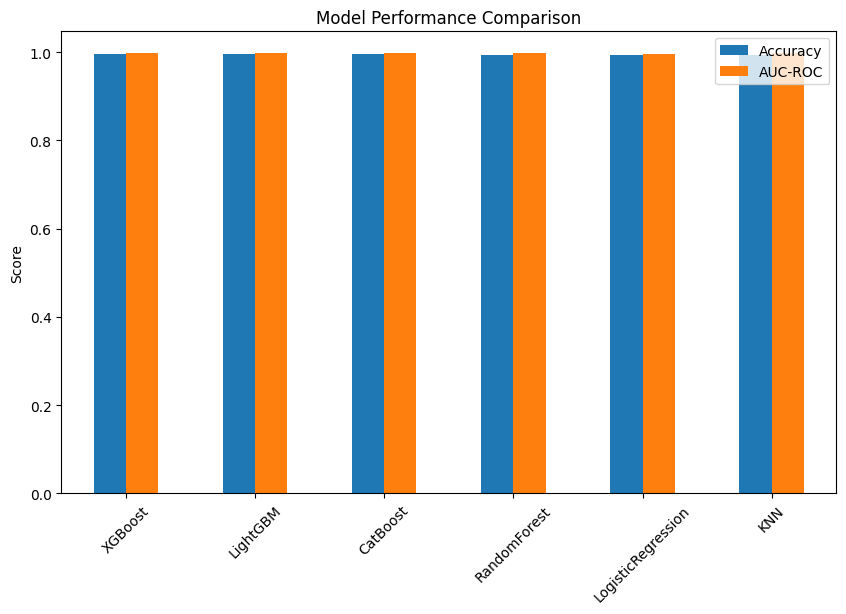

In [43]:
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.show()

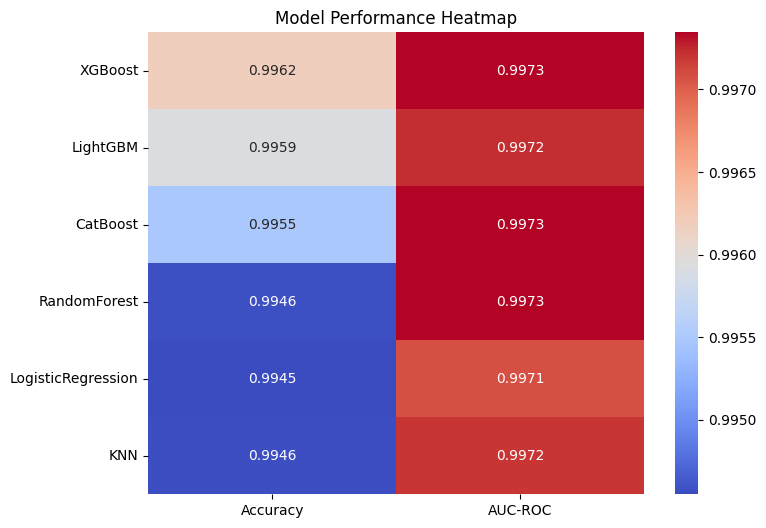

In [44]:
# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Model Performance Heatmap")
plt.show()

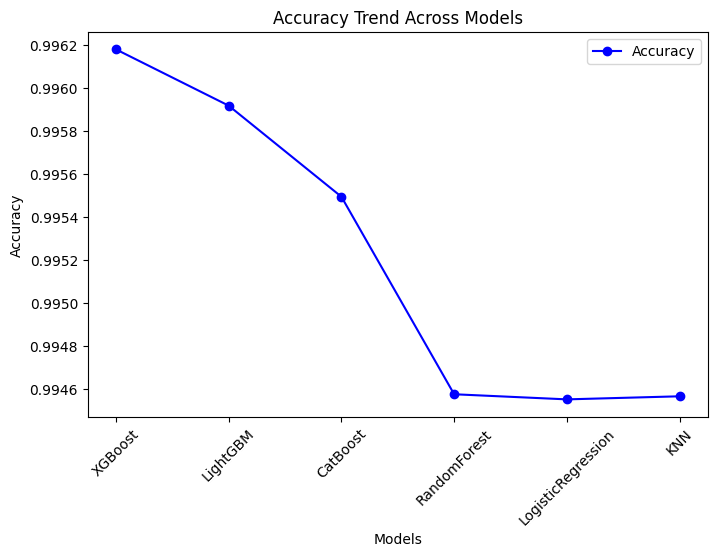

In [45]:
# Line Plot for Accuracy Trend
plt.figure(figsize=(8,5))
plt.plot(results_df.index, results_df['Accuracy'], marker='o', linestyle='-', color='b', label='Accuracy')
plt.title("Accuracy Trend Across Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend()
plt.show()

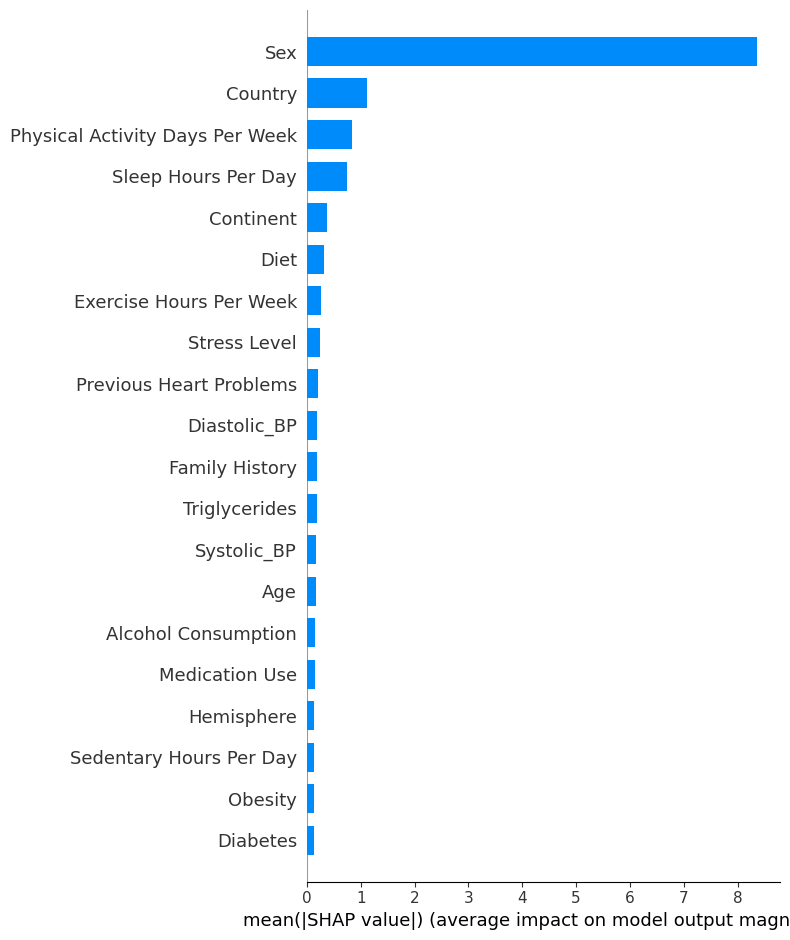

In [50]:
# Ensure X_test has column names
if isinstance(X, pd.DataFrame):
    feature_names = X.columns
else:
    feature_names = ['Feature_' + str(i) for i in range(X.shape[1])]

X_test_df = pd.DataFrame(X_test, columns=feature_names)

# SHAP Values Calculation
explainer = shap.TreeExplainer(models["XGBoost"])
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# Force Plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_df.iloc[0, :])
